<a href="https://colab.research.google.com/github/michael-0907/tibami/blob/main/bank_after_discussion_no_duration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from xgboost import XGBClassifier
import lightgbm as lgb
import os

import joblib

In [87]:
data = pd.read_csv("/content/sample_data/bank-full.csv", encoding="utf-8", sep=";")
display(data.shape)
display(data.head(3))

(45211, 17)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no


In [88]:
df = data.copy()

# 刪除 duration
df = df.drop(columns=["duration"])

# 刪除有疑慮的欄位
df = data.drop(columns=["month", "day"])

# 刪除有unknown的行
df = df[~df.isin(["unknown"]).any(axis=1)]

df.shape


(7842, 15)

In [89]:
# 將balance < 0 的刪除
# balance < 0  的刪除後， padys=-1 的就沒了，pdays的最小值變成 1
df = df[df["balance"] >= 0 ]
df.shape


(7371, 15)

In [90]:
for col in df.columns:
  unknown_col = df[col].isin(["unknown"])
  if unknown_col.any():
    print(f"含有unknown的特徵: {col}, 數量: {unknown_col.sum()}")
unknown_row = df.isin(["unknown"]).any(axis=1)
print(f"總行數: {df.shape[0]}")
print(f"含有unknown的行數: {unknown_row.sum()}")


總行數: 7371
含有unknown的行數: 0


In [91]:
column_info = []
for col in df.columns:
  info_dtype = df[col].dtype
  info_isna = df[col].isna().any()
  info_nunique = df[col].nunique()
  info_min = df[col].min()
  info_max = df[col].max()
  info_unique_20 = df[col].unique()[0: 20]

  c = [col, info_dtype, info_isna, info_nunique, info_min, info_max, info_unique_20]
  column_info.append(c)
columns = ["col_name", "dtype", "isna", "unique_num", "min", "max", "unique_20"]
column_info_df = pd.DataFrame(column_info, columns=columns)
display(column_info_df)

# column_info_df.to_csv("column_info_bank.csv")


,col_name,dtype,isna,unique_num,min,max,unique_20
0,age,int64,False,70,18,89,"[33, 36, 44, 26, 51, 30, 34, 49, 47, 40, 38, 5..."
1,job,object,False,11,admin.,unemployed,"[admin., services, management, blue-collar, te..."
2,marital,object,False,3,divorced,single,"[married, single, divorced]"
3,education,object,False,3,primary,tertiary,"[tertiary, secondary, primary]"
4,default,object,False,2,no,yes,"[no, yes]"
5,balance,int64,False,2764,0,81204,"[882, 3444, 2415, 0, 1324, 172, 3132, 1005, 87..."
6,housing,object,False,2,no,yes,"[no, yes]"
7,loan,object,False,2,no,yes,"[no, yes]"
8,contact,object,False,2,cellular,telephone,"[telephone, cellular]"
9,duration,int64,False,957,5,2219,"[39, 144, 73, 140, 119, 21, 449, 175, 86, 81, ..."


In [92]:
# 目標變數編碼

df[col] = df[col].map({"yes": 1, "no": 0})
# display(df["y"].value_counts())


In [93]:
# 二元特徵及目標變數編碼
ordinal_features = ["default", "housing", "loan"]

for col in ordinal_features:
  df[col] = df[col].map({"yes": 1, "no": 0})



In [94]:
# 提取特徵變數及目標變數

X = df.drop(columns=["y"])
y = df["y"]
print(X.shape, y.shape)


(7371, 14) (7371,)


In [95]:
# 切分訓練組、驗證組、測試組

# 切出測試集(保留最後評估用)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

# 剩下的資料切成訓練、驗證集
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, shuffle=True, stratify=y_temp)
display(X_temp.shape, y_temp.shape)
display(X_test.shape, y_test.shape)
display(X_train.shape, y_train.shape)
display(X_val.shape, y_val.shape)
print(X_train.index.equals(y_train.index))
print(X_test.index.equals(y_test.index))
print(X_val.index.equals(y_val.index))


(5896, 14)

(5896,)

(1475, 14)

(1475,)

(4422, 14)

(4422,)

(1474, 14)

(1474,)

True
True
True


In [96]:
display(X_train.dtypes.value_counts())

,count
int64,9
object,5


In [97]:
# 欄位分類

int_columns = ['age', 'balance', 'campaign', 'pdays', 'previous'] # 數值型欄位，做標準化縮放 # 刪除duration
ordinal_columns = ["education", "contact"] # 類別型欄位，做標籤編碼
binary_columns = ["default", "housing", "loan"] # ["yes", ""no] 二元欄位，前面已轉換，預處理不再做
ohe_columns = ['job', 'marital', 'poutcome'] # 類別型欄位，做ohe


all_columns = int_columns +  ordinal_columns + binary_columns + ohe_columns
print(len(all_columns))
# all_columns


13


In [98]:
# 設置前處理器

categories_order = [
    ["primary", "secondary", "tertiary"],
    ['cellular', 'telephone']
]

preprocessor = ColumnTransformer(transformers=[
    ("int", StandardScaler(), int_columns),
    ("ordinal", OrdinalEncoder(categories=categories_order), ordinal_columns),
    ("passthrough", "passthrough", binary_columns),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ohe_columns)
])


In [99]:
# 執行預處理

X_train_preproceed = preprocessor.fit_transform(X_train) # 訓練組預處理
X_val_preproceed = preprocessor.transform(X_val) # 驗證組預處理

# 儲存預處理器
joblib.dump(preprocessor, "preprocessor.pkl")


['preprocessor.pkl']

In [100]:
# 整理欄位

ohe_columns = list(preprocessor.named_transformers_["ohe"].get_feature_names_out()) # 取得預處理器中的ohe欄位名稱
all_preprocessed_columns = int_columns +  ordinal_columns + binary_columns + ohe_columns # 整合所有欄位名稱
len(all_preprocessed_columns)

X_train_preproceed = pd.DataFrame(X_train_preproceed, columns=all_preprocessed_columns, index=X_train.index) # 訓練組重新生成dataframe
X_val_preproceed = pd.DataFrame(X_val_preproceed, columns=all_preprocessed_columns, index=X_val.index) # 測試組重新生成dataframe

display(X_train_preproceed.shape, y_train.shape)
display(X_val_preproceed.shape, y_val.shape)

display(X_train_preproceed.head(3))
display(X_val_preproceed.head(3))


(4422, 27)

(4422,)

(1474, 27)

(1474,)

,age,balance,campaign,pdays,previous,education,contact,default,housing,loan,...,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success
35777,-0.245234,-0.435792,-0.678116,1.319633,-0.223202,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
40885,0.541785,0.210741,-0.678116,-1.024494,-0.409674,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
37975,-1.207146,-0.441751,-0.042948,1.194375,-0.409674,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


,age,balance,campaign,pdays,previous,education,contact,default,housing,loan,...,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success
41264,-0.332680,-0.468864,-0.678116,-0.228206,-0.409674,2.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
43930,0.891571,-0.506702,1.227388,-1.069229,-0.223202,2.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
34928,-0.595020,-0.260305,-0.678116,0.433875,0.149743,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [109]:
# 定義模型及設定超參數

model_def = {
    "random_forest": {
        "model": RandomForestClassifier(n_estimators=137, max_depth=16, min_samples_leaf=8, class_weight="balanced", random_state=42),
        "cache_path": "/content/rfc_model.pkl"
    },
    "xgb": {
        "model": XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42, n_estimators=100,
                    max_depth=3, learning_rate=0.2, colsample_bytree=0.8, gamma=0.1, min_child_weight=1, scale_pos_weight=2.5,
                    subsample=1, reg_alpha=0.1, reg_lambda=100),
        "cache_path": "/content/xgb_model.pkl"
    },
    "logical_reg": {
        "model": LogisticRegression(penalty='l2', C=0.1, class_weight='balanced', solver='liblinear', max_iter=1000, random_state=42),
        "cache_path": "/content/lr_model.pkl"
    },
    "lgb": {
        "model": lgb.LGBMClassifier(random_state=42, num_leaves=4, max_depth=3, learning_rate=0.015, n_estimators=600, min_child_samples=15,
                      subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=0.1, class_weight="balanced"), # boosting_type = 'gbdt'
        "cache_path": "/content/lgb_model.pkl"
    }
}



In [110]:
# 訓練模型

for name, data in model_def.items():
  path = data["cache_path"]
  if os.path.exists(path):
    print(f"model {name} 已存在")
  else:
    model = data["model"].fit(X_train_preproceed, y_train)
    joblib.dump(model, path)
    print(f"model {name} trained and saved")




model random_forest trained and saved
model xgb trained and saved
model logical_reg trained and saved
[LightGBM] [Info] Number of positive: 1049, number of negative: 3373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 663
[LightGBM] [Info] Number of data points in the train set: 4422, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
model lgb trained and saved


In [111]:
# 對訓練組、驗證組進行預測，並取得 y_score (正類的機率分佈)存在字典 model_result

# 字典，存放訓練組、驗證組的正類分佈機率
model_result = {
    "train_result": {}, "val_result": {}
}

# 預測
for name, data in model_def.items():
  path = data["cache_path"]
  model = joblib.load(path)
  train_score = model.predict_proba(X_train_preproceed)[:, 1] # 對訓練組預測，取得正類的分佈機率
  val_score = model.predict_proba(X_val_preproceed)[:, 1] # 對驗證組預測，取得正類的分佈機率
  model_result["train_result"][name] = train_score
  model_result["val_result"][name] = val_score

for name, score in model_result.items():
  print(name, score)


train_result {'random_forest': array([0.08467813, 0.69906701, 0.13753958, ..., 0.4235535 , 0.73500365,
       0.16440069]), 'xgb': array([0.08199175, 0.7163127 , 0.12867188, ..., 0.2963526 , 0.7797405 ,
       0.10841547], dtype=float32), 'logical_reg': array([0.22148434, 0.8948446 , 0.23894563, ..., 0.49381556, 0.87114645,
       0.16154607]), 'lgb': array([0.12665065, 0.82645732, 0.1635794 , ..., 0.44153693, 0.82809295,
       0.13174783])}
val_result {'random_forest': array([0.69729354, 0.67405941, 0.18981109, ..., 0.18881315, 0.22426761,
       0.13553768]), 'xgb': array([0.6078312 , 0.64324045, 0.16561638, ..., 0.17513905, 0.23521854,
       0.09893762], dtype=float32), 'logical_reg': array([0.76191301, 0.62378362, 0.27738841, ..., 0.34893558, 0.27963658,
       0.23124726]), 'lgb': array([0.73328697, 0.74371982, 0.2047237 , ..., 0.34661353, 0.22152349,
       0.1282981 ])}


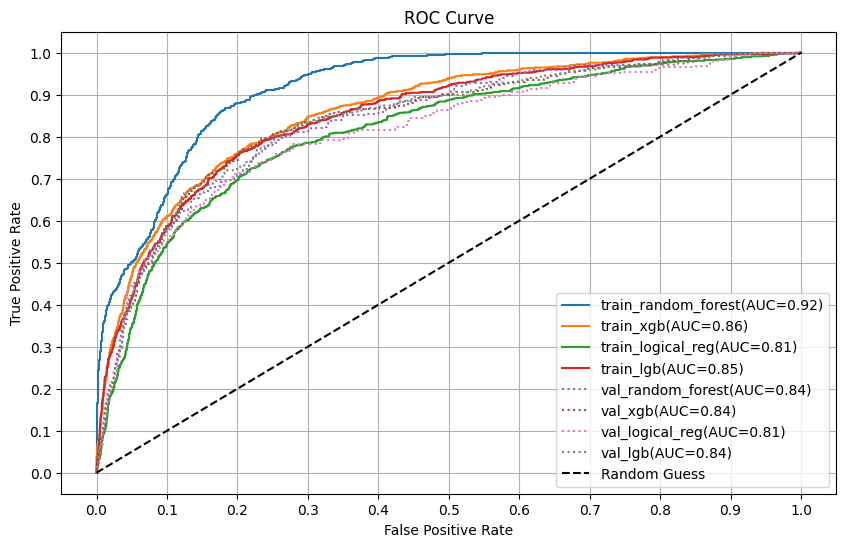

In [112]:
# 畫訓練組、驗證組的 ROC-AUC

plt.figure(figsize=(10, 6))

for k, v in model_result.items():
  for name, result in v.items():
    if k == "train_result": # 畫訓練組的 ROC curve
      fpr, tpr, _ = roc_curve(y_train, result)
      roc_auc = auc(fpr, tpr)
      plt.plot(fpr, tpr, label=f"train_{name}(AUC={roc_auc:.2f})")
    else: # 畫驗證組的 ROC curve
      fpr, tpr, _ = roc_curve(y_val, result)
      roc_auc = auc(fpr, tpr)
      plt.plot(fpr, tpr, ":", label=f"val_{name}(AUC={roc_auc:.2f})")


plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xticks(ticks=np.arange(0, 1.1, 0.1))
plt.yticks(ticks=np.arange(0, 1.1, 0.1))
plt.title("ROC Curve")
plt.legend()
plt.grid(True)




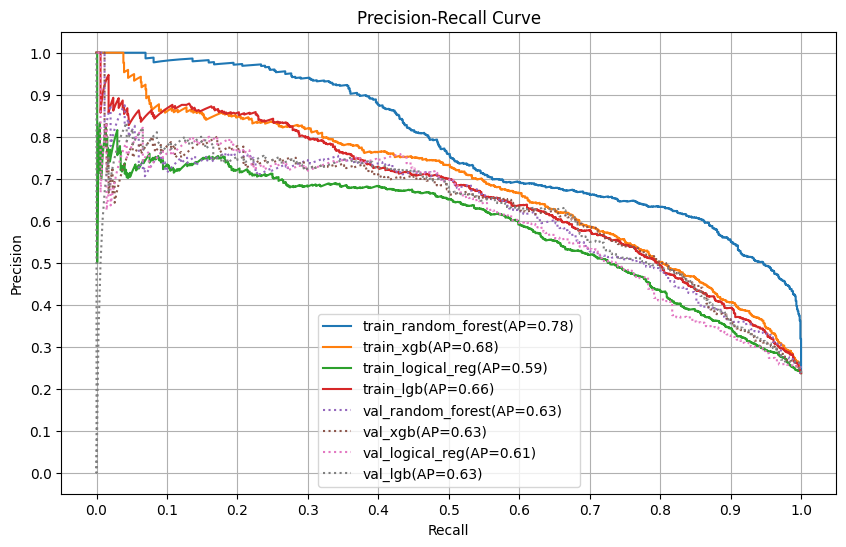

In [113]:
# 畫訓練組、驗證組的 PR-AUC

plt.figure(figsize=(10, 6))

for k, v in model_result.items():
  for name, result in v.items():
    if k == "train_result": # 畫訓練組的 PR curve
      precision, recall, _ = precision_recall_curve(y_train, result)
      ap_score = average_precision_score(y_train, result)
      plt.plot(recall, precision, label=f"train_{name}(AP={ap_score:.2f})")
    else: # 畫驗證組的 PR curve
      precision, recall, _ = precision_recall_curve(y_val, result)
      ap_score = average_precision_score(y_val, result)
      plt.plot(recall, precision, ":", label=f"val_{name}(AP={ap_score:.2f})")


plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xticks(ticks=np.arange(0, 1.1, 0.1))
plt.yticks(ticks=np.arange(0, 1.1, 0.1))
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)

# rfc 過擬合，xgb 最穩定, logical reg 訓練比驗證差




(27,)

27

poutcome_success: 0.5030044317245483
housing: 0.20698796212673187
poutcome_failure: 0.06298065185546875
job_blue-collar: 0.026955556124448776
pdays: 0.02582092583179474
education: 0.021527519449591637
loan: 0.018536105751991272
marital_single: 0.01787138544023037
job_entrepreneur: 0.014710502699017525
job_admin.: 0.012050622142851353
previous: 0.011398431845009327
campaign: 0.011265411041676998
balance: 0.010343977250158787
['poutcome_success', 'housing', 'poutcome_failure', 'job_blue-collar', 'pdays', 'education', 'loan', 'marital_single', 'job_entrepreneur', 'job_admin.', 'previous', 'campaign', 'balance']


<Axes: xlabel='importance', ylabel='feature'>

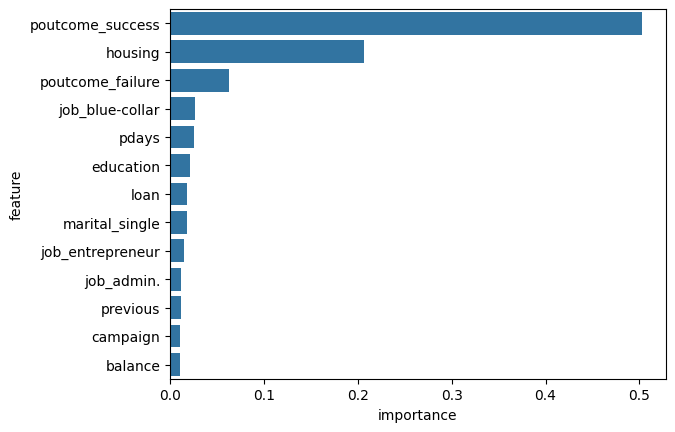

In [153]:
# 找出 xgb 的 feature importance

model = joblib.load("/content/xgb_model.pkl")
feature_importance = model.feature_importances_
display(feature_importance.shape, len(X_train_preproceed.columns))

sorted_index = np.argsort(feature_importance)[::-1]
sorted_columns = np.array(X_train_preproceed.columns)[sorted_index]
sorted_importance = feature_importance[sorted_index]

feature_select = []
importance_select = []
threshold = 0.01
for i, j in zip(sorted_columns, sorted_importance):
  if j >= threshold:
    print(f"{i}: {j}")
    feature_select.append(i)
    importance_select.append(j)


print(feature_select)

data = {"feature": feature_select, "importance": importance_select}

important_df = pd.DataFrame(data=data)
sns.barplot(data=important_df, y="feature", x="importance")


# ['poutcome', 'housing', 'job', 'pdays', 'education', 'loan', 'marital', 'previous', 'campaign', 'balance']



# 到此為止，選完模型和特徵選擇

In [120]:

model = joblib.load("/content/rfc_model.pkl")
y_score = model.predict_proba(X_val_preproceed)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_val, y_score)


In [139]:
# 在預設門檻值0.5下，把每個模型的 accuracy, precision, recall, f1-score, tn, fn, tp, fp 抓出來


def predict(name, model, X, y):
  y_score = model.predict_proba(X)[:, 1] # 對訓練組預測，取得正類的分佈機率

  fpr, tpr, _ = roc_curve(y, y_score)
  roc_auc = auc(fpr, tpr).round(4)

  precisions, recalls, thresholds = precision_recall_curve(y, y_score)
  ap_score = average_precision_score(y, y_score).round(4)

  f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
  best_idx = np.argmax(f1s)
  best_threshold = thresholds[best_idx].round(4)
  best_f1 = f1s[best_idx].round(4)

  threshold = 0.5
  y_pred = (y_score >= threshold).astype(int)
  tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

  value = {"name": name, "y_score": y_score, "roc_auc": roc_auc, "ap_score": ap_score, "f1s": f1s,
        "best_threshold": best_threshold, "best_f1": best_f1, "y_pred": y_pred, "tn": tn, "fp": fp, "fn": fn, "tp": tp}
  # print(value)
  return value

# 對訓練組、驗證組進行預測，並取得 y_score (正類的機率分佈)存在字典 model_result

# 字典，存放訓練組、驗證組的正類分佈機率
model_result_1 = {
    "train_result": [], "val_result": []
}

# 預測
for name, data in model_def.items():
  path = data["cache_path"]
  model = joblib.load(path)

  train_value = predict(name, model, X_train_preproceed, y_train)
  val_value = predict(name, model, X_val_preproceed, y_val)

  model_result_1["train_result"].append(train_value)
  model_result_1["val_result"].append(val_value)



In [140]:
train_result_df = pd.DataFrame(model_result_1["train_result"])
val_result_df = pd.DataFrame(model_result_1["val_result"])
all_df = pd.concat([train_result_df, val_result_df], axis=0)

In [141]:
all_df.to_csv("result.csv", index=False, float_format="%.2f")
all_df.to_excel("result.xlsx", index=False, float_format="%.2f")

In [137]:
val_result_df

,name,y_score,roc_auc,ap_score,f1s,best_threshold,best_f1,y_pred,tn,fp,fn,tp
0,random_forest,"[0.6972935446665636, 0.6740594091790484, 0.189...",0.8376,0.6253,"[0.38377192672324667, 0.3839824434141188, 0.38...",0.5141,0.6247,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...",959,165,120,230
1,xgb,"[0.6078312, 0.64324045, 0.16561638, 0.18764634...",0.8397,0.6288,"[0.38377192672324667, 0.3839824434141188, 0.38...",0.4948,0.6400,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...",951,173,105,245
2,logical_reg,"[0.7619130131004518, 0.623783616287558, 0.2773...",0.8137,0.6106,"[0.38377192672324667, 0.3839824434141188, 0.38...",0.5271,0.6091,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...",898,226,100,250
3,lgb,"[0.733286974033198, 0.7437198229222026, 0.2047...",0.8386,0.6252,"[0.38377192672324667, 0.3839824434141188, 0.38...",0.5827,0.6462,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...",896,228,95,255


In [129]:
model_result_1["train_result"]


[{'name': 'random_forest',
  'y_score': array([0.08467813, 0.69906701, 0.13753958, ..., 0.4235535 , 0.73500365,
         0.16440069]),
  'roc_auc': np.float64(0.9161),
  'ap_score': np.float64(0.7795),
  'f1s': array([0.38347651, 0.38354661, 0.38361675, ..., 0.0038059 , 0.00190476,
         0.        ]),
  'best_threshold': np.float64(0.4664),
  'best_f1': np.float64(0.7097),
  'y_pred': array([0, 1, 0, ..., 0, 1, 0]),
  'tn': np.int64(2914),
  'fp': np.int64(459),
  'fn': np.int64(237),
  'tp': np.int64(812)},
 {'name': 'xgb',
  'y_score': array([0.08199175, 0.7163127 , 0.12867188, ..., 0.2963526 , 0.7797405 ,
         0.10841547], dtype=float32),
  'roc_auc': np.float64(0.8598),
  'ap_score': np.float64(0.6836),
  'f1s': array([0.38347651, 0.38354661, 0.38361675, ..., 0.0038059 , 0.00190476,
         0.        ]),
  'best_threshold': np.float32(0.5472),
  'best_f1': np.float64(0.6435),
  'y_pred': array([0, 1, 0, ..., 0, 1, 0]),
  'tn': np.int64(2850),
  'fp': np.int64(523),
  'fn': 

In [50]:
model_def

{'random_forest': {'model': RandomForestClassifier(class_weight='balanced', max_depth=16,
                         min_samples_leaf=8, n_estimators=137, random_state=42),
  'cache_path': '/content/rf_model.pkl'},
 'xgb': {'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=0.8, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric='logloss',
                feature_types=None, gamma=0.1, grow_policy=None,
                importance_type=None, interaction_constraints=None,
                learning_rate=0.2, max_bin=None, max_cat_threshold=None,
                max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
                max_leaves=None, min_child_weight=1, missing=nan,
                monotone_constraints=None, multi_strategy=None, n_estimators=100,
                n_jobs=None, num_parallel_tree=None, random_state=42, ...

# 以下不要看

In [42]:
# import optuna


# # 定义目标函数
# def objective(trial):
#     model_name = trial.suggest_categorical('model', ['RandomForest', 'XGBClassifier', 'LogisticRegression', 'LGBMClassifier'])

#     if model_name == 'RandomForest':
#         n_estimators = trial.suggest_int('n_estimators', 10, 150)
#         max_depth = trial.suggest_int('max_depth', 3, 20)
#         min_samples_split = trial.suggest_int('min_samples_split', 2, 20)

#         model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
#                                        min_samples_split=min_samples_split, class_weight='balanced', random_state=42)

#     elif model_name == "XGBClassifier":
#         max_depth = trial.suggest_int('max_depth', 3, 10)
#         learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
#         n_estimators = trial.suggest_int('n_estimators', 50, 300)
#         subsample = trial.suggest_float('subsample', 0.5, 1.0)
#         colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
#         gamma = trial.suggest_float('gamma', 0, 5)
#         scale_pos_weight = trial.suggest_int('scale_pos_weight', 1, 10)  # 用于处理类别不平衡
#         min_child_weight = trial.suggest_int('min_child_weight', 1, 10)

#         model = XGBClassifier(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators,
#                               subsample=subsample, colsample_bytree=colsample_bytree, gamma=gamma,
#                               scale_pos_weight=scale_pos_weight, min_child_weight=min_child_weight,
#                               use_label_encoder=False, eval_metric='logloss', random_state=42)

#     elif model_name == 'LogisticRegression':
#         C = trial.suggest_float('C', 1e-5, 1e5, log=True)
#         max_iter = trial.suggest_int('max_iter', 50, 1000)
#         penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
#         solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
#         tol = trial.suggest_float('tol', 1e-6, 1e-4, log=True)
#         class_weight = trial.suggest_categorical('class_weight', ['balanced', None])

#         model = LogisticRegression(C=C, max_iter=max_iter, penalty=penalty, solver=solver,
#                                    tol=tol, class_weight=class_weight, random_state=42)

#     elif model_name == 'LGBMClassifier':
#         num_leaves = trial.suggest_int('num_leaves', 2, 255)
#         max_depth = trial.suggest_int('max_depth', 3, 15)
#         learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2)
#         n_estimators = trial.suggest_int('n_estimators', 50, 600)
#         subsample = trial.suggest_float('subsample', 0.5, 1.0)
#         colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
#         scale_pos_weight = trial.suggest_int('scale_pos_weight', 1, 10)
#         min_child_weight = trial.suggest_int('min_child_weight', 1, 15)
#         reg_alpha = trial.suggest_float('reg_alpha', 0.0, 10.0)  # L1 正则化
#         reg_lambda = trial.suggest_float('reg_lambda', 0.0, 10.0)  # L2 正则化

#         model = lgb.LGBMClassifier(num_leaves=num_leaves, max_depth=max_depth, learning_rate=learning_rate,
#                                    n_estimators=n_estimators, subsample=subsample, colsample_bytree=colsample_bytree,
#                                    scale_pos_weight=scale_pos_weight, min_child_weight=min_child_weight, random_state=42,
#                                    reg_alpha=reg_alpha, reg_lambda=reg_lambda, class_weight="balanced")

#     # 训练模型
#     model.fit(X_train_preproceed, y_train)  # 训练模型
#     y_val_pred = model.predict_proba(X_val_preproceed)[:, 1]  # 取得验证集的正类预测概率

#     # 计算 AUC 作为优化指标
#     auc_score = roc_auc_score(y_val, y_val_pred)

#     return auc_score  # 返回 AUC 作为优化目标

# # 创建 Optuna Study 对象
# study = optuna.create_study(direction='maximize')

# # 开始优化
# study.optimize(objective, n_trials=10)

# # 输出最佳超参数和性能
# print("Best hyperparameters:", study.best_params)
# print("Best AUC:", study.best_value)


In [43]:


# 在預設門檻值0.5下，把每個模型的 accuracy, precision, recall, f1-score, tn, fn, tp, fp 抓出來
# def metrics(data, result):
#   precisions, recalls, thresholds = precision_recall_curve(data, result)
#   ap_score = average_precision_score(data, result)
#   f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
#   best_idx = np.argmax(f1s)
#   threshold = thresholds[best_idx]
#   y_pred = (result >= threshold).astype(int)
#   tn, fp, fn, tp = confusion_matrix(data, y_pred).ravel()
#   return precisions, recalls, ap_score

# 畫訓練組、驗證組的 PR-AUC

# plt.figure(figsize=(10, 6))
# for k, v in model_result.items():
#   for name, result in v.items():
#     if k == "train_result": # 畫訓練組的 PR curve
#       precisions, recalls, ap_score = metrics(y_train, result)
#       plt.plot(recalls, precisions, label=f"train_{name}(AP={ap_score:.2f})")
#     else: # 畫驗證組的 PR curve
#       precisions, recalls, ap_score = metrics(y_val, result)
#       plt.plot(recalls, precisions, ":",label=f"train_{name}(AP={ap_score:.2f})")


# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.xticks(ticks=np.arange(0, 1.1, 0.1))
# plt.yticks(ticks=np.arange(0, 1.1, 0.1))
# plt.title("Precision-Recall Curve")
# plt.legend()
# plt.grid(True)

# rfc 過擬合，xgb 最穩定, logical reg 訓練比驗證差


